# Enhanced XGBoost with STFT Features and SMOTE

This notebook integrates STFT-derived features with traditional clinical features and applies SMOTE for class balancing to create a robust sepsis prediction model.

## Key Components
1. **Feature Integration**: Combine traditional features with STFT frequency-domain features
2. **SMOTE Application**: Handle class imbalance with temporal-aware synthetic sampling
3. **XGBoost Optimization**: Hyperparameter tuning for optimal performance
4. **Feature Selection**: Identify most predictive features across domains
5. **Medical Validation**: Ensure clinical interpretability and safety

## Technical Approach
- Temporal-aware SMOTE to preserve medical time series structure
- Multi-domain feature fusion (time, frequency, clinical)
- Advanced XGBoost with early stopping and cross-validation
- Clinical constraint enforcement
- Comprehensive model evaluation and interpretation

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
import joblib
from datetime import datetime

# Machine learning libraries
import xgboost as xgb
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, 
    RandomizedSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier

# SMOTE and imbalanced learning
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced

# Advanced plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"SMOTE available: {hasattr(imblearn.over_sampling, 'SMOTE')}")

Libraries imported successfully!
XGBoost version: 3.0.5
SMOTE available: True


In [3]:
# Configuration and paths
PROCESSED_DATA_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\data\processed"
STFT_DATA_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\data\stft_features"
MODEL_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\models"
RESULTS_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\results"

# Create results directory
os.makedirs(RESULTS_PATH, exist_ok=True)

# Model configuration
MODEL_CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'cv_folds': 5,
    'smote_k_neighbors': 5,
    'max_features_select': 100,
    'early_stopping_rounds': 50,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic'
}

print(f"Configuration loaded:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")
print(f"\nResults will be saved to: {RESULTS_PATH}")

Configuration loaded:
  random_state: 42
  test_size: 0.2
  cv_folds: 5
  smote_k_neighbors: 5
  max_features_select: 100
  early_stopping_rounds: 50
  eval_metric: logloss
  objective: binary:logistic

Results will be saved to: C:\Users\sachi\Desktop\Sepsis STFT\results


In [5]:
# Load preprocessed traditional features
print("=== LOADING TRADITIONAL FEATURES ===")

try:
    # Check if traditional data exists, if not, create placeholder with required columns
    traditional_path = os.path.join(PROCESSED_DATA_PATH, 'preprocessed_data_subset.csv')
    feature_columns_path = os.path.join(PROCESSED_DATA_PATH, 'feature_columns.txt')
    
    if os.path.exists(traditional_path) and os.path.exists(feature_columns_path):
        traditional_data = pd.read_csv(traditional_path)
        # Load feature columns
        with open(feature_columns_path, 'r') as f:
            traditional_feature_columns = [line.strip() for line in f.readlines()]
        print(f"Traditional features loaded: {traditional_data.shape}")
        print(f"Traditional feature columns: {len(traditional_feature_columns)}")
    else:
        print("Traditional features not found. Creating minimal structure for STFT-only modeling.")
        # We'll create a placeholder for the traditional data structure
        traditional_data = None
        traditional_feature_columns = []
    
except Exception as e:
    print(f"Error loading traditional features: {str(e)}")
    print("Creating minimal structure for STFT-only modeling.")
    traditional_data = None
    traditional_feature_columns = []

# Load STFT features
print("\n=== LOADING STFT FEATURES ===")

try:
    # First try CSV files
    train_stft = pd.read_csv(os.path.join(STFT_DATA_PATH, 'train_stft_scaled.csv'))
    val_stft = pd.read_csv(os.path.join(STFT_DATA_PATH, 'val_stft_scaled.csv'))
    test_stft = pd.read_csv(os.path.join(STFT_DATA_PATH, 'test_stft_scaled.csv'))
    
    print(f"STFT features loaded:")
    print(f"  Train: {train_stft.shape}")
    print(f"  Validation: {val_stft.shape}")
    print(f"  Test: {test_stft.shape}")
    
    # Get STFT feature columns (excluding metadata columns like patient_id, SepsisLabel, etc.)
    # Note: We'll dynamically determine them from the dataframe
    metadata_cols = ['patient_id', 'SepsisLabel', 'ICU_LOS', 'Age', 'Gender']
    stft_feature_columns = [col for col in train_stft.columns if col not in metadata_cols]
    
    print(f"STFT feature columns: {len(stft_feature_columns)}")
    
except FileNotFoundError:
    print("STFT features not found in CSV format. Please run 05_enhanced_stft_preprocessing.ipynb first.")
    raise

# Extract patient IDs from the STFT datasets - using 'patient_id' column instead of 'PatientID'
train_patients = train_stft['patient_id'].unique()
val_patients = val_stft['patient_id'].unique() if 'patient_id' in val_stft.columns else []
test_patients = test_stft['patient_id'].unique() if 'patient_id' in test_stft.columns else []

print(f"\nPatient splits: {len(train_patients)}/{len(val_patients)}/{len(test_patients)}")

=== LOADING TRADITIONAL FEATURES ===
Traditional features not found. Creating minimal structure for STFT-only modeling.

=== LOADING STFT FEATURES ===
STFT features loaded:
  Train: (68, 537)
  Validation: (15, 537)
  Test: (15, 537)
STFT feature columns: 532

Patient splits: 68/15/15


In [6]:
# Create patient-level traditional features
print("=== CREATING PATIENT-LEVEL TRADITIONAL FEATURES ===")

def create_patient_level_features(data, patients, feature_columns):
    """Aggregate time series data to patient level"""
    patient_features = []
    
    # If we don't have traditional data, return an empty dataframe with just the patient IDs
    if data is None:
        return pd.DataFrame({'patient_id': patients})
    
    for patient_id in patients:
        patient_data = data[data['PatientID'] == patient_id]
        
        if len(patient_data) == 0:
            continue
        
        # Initialize patient feature dictionary
        patient_feat = {'patient_id': patient_id}  # Changed to match STFT column name
        
        # Target variable
        patient_feat['SepsisLabel'] = patient_data['SepsisLabel'].max()
        
        # Basic demographics (constant for patient)
        patient_feat['Age'] = patient_data['Age'].iloc[0]
        patient_feat['Gender'] = patient_data['Gender'].iloc[0]
        patient_feat['ICU_Length'] = patient_data['ICULOS'].max() if 'ICULOS' in patient_data.columns else 0
        
        # Aggregate time-varying features
        numeric_features = [col for col in feature_columns 
                          if col in patient_data.columns and 
                          col not in ['PatientID', 'SepsisLabel', 'ICULOS', 'HospAdmTime', 'Unit1', 'Unit2']]
        
        for feature in numeric_features:
            if patient_data[feature].dtype in ['float64', 'int64']:
                # Multiple aggregations for each feature
                patient_feat[f'{feature}_mean'] = patient_data[feature].mean()
                patient_feat[f'{feature}_std'] = patient_data[feature].std()
                patient_feat[f'{feature}_min'] = patient_data[feature].min()
                patient_feat[f'{feature}_max'] = patient_data[feature].max()
                patient_feat[f'{feature}_median'] = patient_data[feature].median()
                
                # Trend (slope of linear fit)
                if len(patient_data) > 1:
                    time_indices = np.arange(len(patient_data))
                    try:
                        slope = np.polyfit(time_indices, patient_data[feature].fillna(method='ffill'), 1)[0]
                        patient_feat[f'{feature}_trend'] = slope
                    except:
                        patient_feat[f'{feature}_trend'] = 0
                else:
                    patient_feat[f'{feature}_trend'] = 0
        
        patient_features.append(patient_feat)
    
    return pd.DataFrame(patient_features)

# Handle the case where we might not have traditional data
if traditional_data is not None:
    # Create patient-level traditional features
    print("Creating train traditional features...")
    train_traditional = create_patient_level_features(
        traditional_data[traditional_data['PatientID'].isin(train_patients)], 
        train_patients, traditional_feature_columns
    )

    print("Creating validation traditional features...")
    val_traditional = create_patient_level_features(
        traditional_data[traditional_data['PatientID'].isin(val_patients)], 
        val_patients, traditional_feature_columns
    )

    print("Creating test traditional features...")
    test_traditional = create_patient_level_features(
        traditional_data[traditional_data['PatientID'].isin(test_patients)], 
        test_patients, traditional_feature_columns
    )

    print(f"\nPatient-level traditional features:")
    print(f"  Train: {train_traditional.shape}")
    print(f"  Validation: {val_traditional.shape}")
    print(f"  Test: {test_traditional.shape}")
else:
    # Create simplified dataframes with just patient IDs
    print("No traditional data available. Creating minimal patient-level dataframes...")
    train_traditional = pd.DataFrame({'patient_id': train_patients})
    val_traditional = pd.DataFrame({'patient_id': val_patients})
    test_traditional = pd.DataFrame({'patient_id': test_patients})
    
    print(f"\nMinimal patient-level dataframes created:")
    print(f"  Train: {train_traditional.shape}")
    print(f"  Validation: {val_traditional.shape}")
    print(f"  Test: {test_traditional.shape}")

=== CREATING PATIENT-LEVEL TRADITIONAL FEATURES ===
No traditional data available. Creating minimal patient-level dataframes...

Minimal patient-level dataframes created:
  Train: (68, 1)
  Validation: (15, 1)
  Test: (15, 1)


In [7]:
# Integrate traditional and STFT features
print("=== INTEGRATING TRADITIONAL AND STFT FEATURES ===")

def merge_features(traditional_df, stft_df):
    """Merge traditional and STFT features on patient ID"""
    # Use 'patient_id' as the join column
    merged_df = pd.merge(traditional_df, stft_df, on='patient_id', how='inner', suffixes=('_trad', '_stft'))
    
    # Handle duplicate columns
    columns_to_drop = []
    for col in merged_df.columns:
        if col.endswith('_stft') and col.replace('_stft', '_trad') in merged_df.columns:
            # Keep traditional version for metadata, drop STFT version
            if col.replace('_stft', '') in ['SepsisLabel', 'Age', 'Gender', 'ICU_Length', 'ICU_LOS']:
                columns_to_drop.append(col)
    
    if columns_to_drop:
        merged_df = merged_df.drop(columns=columns_to_drop)
        print(f"Dropped {len(columns_to_drop)} duplicate columns")
    
    # Rename traditional suffixed columns
    rename_dict = {}
    for col in merged_df.columns:
        if col.endswith('_trad'):
            rename_dict[col] = col.replace('_trad', '')
    
    merged_df = merged_df.rename(columns=rename_dict)
    
    return merged_df

# Merge features for all splits
print("Merging train features...")
train_integrated = merge_features(train_traditional, train_stft)

print("Merging validation features...")
val_integrated = merge_features(val_traditional, val_stft)

print("Merging test features...")
test_integrated = merge_features(test_traditional, test_stft)

print(f"\nIntegrated features:")
print(f"  Train: {train_integrated.shape}")
print(f"  Validation: {val_integrated.shape}")
print(f"  Test: {test_integrated.shape}")

# Let's examine the distribution of the target variable
print(f"\nTarget Distribution:")
print(f"  Train: {train_integrated['SepsisLabel'].value_counts().to_dict()}")
if 'SepsisLabel' in val_integrated.columns:
    print(f"  Validation: {val_integrated['SepsisLabel'].value_counts().to_dict()}")
if 'SepsisLabel' in test_integrated.columns:
    print(f"  Test: {test_integrated['SepsisLabel'].value_counts().to_dict()}")

=== INTEGRATING TRADITIONAL AND STFT FEATURES ===
Merging train features...
Merging validation features...
Merging test features...

Integrated features:
  Train: (68, 537)
  Validation: (15, 537)
  Test: (15, 537)

Target Distribution:
  Train: {0: 62, 1: 6}
  Validation: {0: 13, 1: 2}
  Test: {0: 14, 1: 1}


In [8]:
# Prepare data for modeling
print("=== PREPARING DATA FOR MODELING ===")

# Define feature columns for modeling - excluding non-feature columns
exclude_cols = ['patient_id', 'SepsisLabel', 'ICU_LOS', 'Age', 'Gender']
all_feature_cols = [col for col in train_integrated.columns if col not in exclude_cols]
print(f"Total modeling features: {len(all_feature_cols)}")

# Prepare training data
X_train = train_integrated[all_feature_cols].fillna(0)
y_train = train_integrated['SepsisLabel']

# Prepare validation data
X_val = val_integrated[all_feature_cols].fillna(0)
y_val = val_integrated['SepsisLabel']

# Prepare test data
X_test = test_integrated[all_feature_cols].fillna(0)
y_test = test_integrated['SepsisLabel']

# Replace infinite values
X_train = X_train.replace([np.inf, -np.inf], 0)
X_val = X_val.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

print(f"Modeling data shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nClass distribution:")
print(f"  Train: {np.bincount(y_train)}")
print(f"  Val: {np.bincount(y_val)}")
print(f"  Test: {np.bincount(y_test)}")

# Check for missing values
print(f"\nMissing values:")
print(f"  X_train: {X_train.isnull().sum().sum()}")
print(f"  X_val: {X_val.isnull().sum().sum()}")
print(f"  X_test: {X_test.isnull().sum().sum()}")

# Data quality checks
print(f"\nData quality:")
print(f"  Infinite values in X_train: {np.isinf(X_train.values).sum()}")
print(f"  Constant features: {(X_train.nunique() <= 1).sum()}")

# Remove constant features if any
constant_features = X_train.columns[X_train.nunique() <= 1]
if len(constant_features) > 0:
    print(f"Removing {len(constant_features)} constant features")
    X_train = X_train.drop(columns=constant_features)
    X_val = X_val.drop(columns=constant_features)
    X_test = X_test.drop(columns=constant_features)
    all_feature_cols = [col for col in all_feature_cols if col not in constant_features]
    
    print(f"Updated feature count: {len(all_feature_cols)}")

=== PREPARING DATA FOR MODELING ===
Total modeling features: 532
Modeling data shapes:
  X_train: (68, 532), y_train: (68,)
  X_val: (15, 532), y_val: (15,)
  X_test: (15, 532), y_test: (15,)

Class distribution:
  Train: [62  6]
  Val: [13  2]
  Test: [14  1]

Missing values:
  X_train: 0
  X_val: 0
  X_test: 0

Data quality:
  Infinite values in X_train: 0
  Constant features: 57
Removing 57 constant features
Updated feature count: 475


In [9]:
# Apply SMOTE for class balancing
print("=== APPLYING SMOTE FOR CLASS BALANCING ===")

# Check if we have enough minority samples for SMOTE
minority_count = min(np.bincount(y_train))
print(f"Minority class count: {minority_count}")

if minority_count >= MODEL_CONFIG['smote_k_neighbors']:
    # Apply different SMOTE variants
    smote_variants = {
        'SMOTE': SMOTE(random_state=MODEL_CONFIG['random_state'], k_neighbors=MODEL_CONFIG['smote_k_neighbors']),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=MODEL_CONFIG['random_state'], k_neighbors=MODEL_CONFIG['smote_k_neighbors']),
        'ADASYN': ADASYN(random_state=MODEL_CONFIG['random_state'], n_neighbors=MODEL_CONFIG['smote_k_neighbors'])
    }
    
    smote_results = {}
    
    for smote_name, smote_method in smote_variants.items():
        try:
            print(f"\nApplying {smote_name}...")
            X_train_smote, y_train_smote = smote_method.fit_resample(X_train, y_train)
            
            print(f"  Original distribution: {np.bincount(y_train)}")
            print(f"  SMOTE distribution: {np.bincount(y_train_smote)}")
            print(f"  Shape change: {X_train.shape} -> {X_train_smote.shape}")
            
            smote_results[smote_name] = (X_train_smote, y_train_smote)
            
        except Exception as e:
            print(f"  Error with {smote_name}: {e}")
    
    # Select the best SMOTE variant (use regular SMOTE as default)
    if 'SMOTE' in smote_results:
        X_train_balanced, y_train_balanced = smote_results['SMOTE']
        chosen_smote = 'SMOTE'
    elif smote_results:
        chosen_smote = list(smote_results.keys())[0]
        X_train_balanced, y_train_balanced = smote_results[chosen_smote]
    else:
        print("No SMOTE variant worked, using original data")
        X_train_balanced, y_train_balanced = X_train, y_train
        chosen_smote = 'None'
    
    print(f"\nChosen SMOTE variant: {chosen_smote}")
    print(f"Final balanced data shape: {X_train_balanced.shape}")
    print(f"Final class distribution: {np.bincount(y_train_balanced)}")
    
else:
    print(f"Insufficient minority samples ({minority_count}) for SMOTE. Using original data.")
    X_train_balanced, y_train_balanced = X_train, y_train
    chosen_smote = 'None'

# Store SMOTE metadata
smote_metadata = {
    'method': chosen_smote,
    'original_shape': X_train.shape,
    'balanced_shape': X_train_balanced.shape,
    'original_distribution': np.bincount(y_train).tolist(),
    'balanced_distribution': np.bincount(y_train_balanced).tolist(),
    'k_neighbors': MODEL_CONFIG['smote_k_neighbors']
}

=== APPLYING SMOTE FOR CLASS BALANCING ===
Minority class count: 6

Applying SMOTE...
  Original distribution: [62  6]
  SMOTE distribution: [62 62]
  Shape change: (68, 475) -> (124, 475)

Applying BorderlineSMOTE...
  Original distribution: [62  6]
  SMOTE distribution: [62 62]
  Shape change: (68, 475) -> (124, 475)

Applying ADASYN...
  Original distribution: [62  6]
  SMOTE distribution: [62 64]
  Shape change: (68, 475) -> (126, 475)

Chosen SMOTE variant: SMOTE
Final balanced data shape: (124, 475)
Final class distribution: [62 62]
  Original distribution: [62  6]
  SMOTE distribution: [62 62]
  Shape change: (68, 475) -> (124, 475)

Applying BorderlineSMOTE...
  Original distribution: [62  6]
  SMOTE distribution: [62 62]
  Shape change: (68, 475) -> (124, 475)

Applying ADASYN...
  Original distribution: [62  6]
  SMOTE distribution: [62 64]
  Shape change: (68, 475) -> (126, 475)

Chosen SMOTE variant: SMOTE
Final balanced data shape: (124, 475)
Final class distribution: [62 

In [11]:
# Feature selection for optimal performance
print("=== FEATURE SELECTION ===")

# Define feature categories based on naming patterns
traditional_cols = [col for col in all_feature_cols if not any(stft_keyword in col for stft_keyword in ['_stft_', 'stft'])]
stft_cols = [col for col in all_feature_cols if any(stft_keyword in col for stft_keyword in ['_stft_', 'stft'])]

print(f"Feature categorization:")
print(f"  Traditional features: {len(traditional_cols)}")
print(f"  STFT features: {len(stft_cols)}")
print(f"  Total features: {len(all_feature_cols)}")

# Univariate feature selection
print("\nPerforming univariate feature selection...")
k_best = min(MODEL_CONFIG['max_features_select'], X_train_balanced.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = np.array(all_feature_cols)[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

print(f"Selected {len(selected_features)} features out of {len(all_feature_cols)}")

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
}).sort_values('Score', ascending=False)

print(f"\nTop 15 selected features:")
display(feature_importance_df.head(15))

# Analyze feature types in selection
selected_traditional = [f for f in selected_features if f in traditional_cols]
selected_stft = [f for f in selected_features if f in stft_cols]

print(f"\nSelected feature breakdown:")
print(f"  Traditional: {len(selected_traditional)} ({len(selected_traditional)/len(selected_features)*100:.1f}%)")
print(f"  STFT: {len(selected_stft)} ({len(selected_stft)/len(selected_features)*100:.1f}%)")

# Feature type analysis for STFT features
if selected_stft:
    stft_feature_types = {
        'spectral': len([f for f in selected_stft if 'spectral' in f]),
        'temporal': len([f for f in selected_stft if 'temporal' in f]),
        'band_specific': len([f for f in selected_stft if any(band in f for band in ['ultra_slow', 'slow', 'moderate', 'fast'])])
    }
    
    print(f"\nSelected STFT feature types:")
    for ftype, count in stft_feature_types.items():
        print(f"  {ftype}: {count} features")

=== FEATURE SELECTION ===
Feature categorization:
  Traditional features: 0
  STFT features: 475
  Total features: 475

Performing univariate feature selection...
Selected 100 features out of 475

Top 15 selected features:


,Feature,Score
44,Temp_stft_moderate_spectral_centroid,57.187253
38,Temp_stft_slow_spectral_centroid,57.186913
26,Temp_stft_spectral_entropy,57.183332
27,Temp_stft_spectral_flatness,57.154546
25,Temp_stft_spectral_spread,57.142749
23,Temp_stft_max_power,57.060060
47,Temp_stft_fast_max_power,57.017909
41,Temp_stft_moderate_max_power,56.966058
35,Temp_stft_slow_max_power,56.963586
24,Temp_stft_spectral_centroid,56.691180



Selected feature breakdown:
  Traditional: 0 (0.0%)
  STFT: 100 (100.0%)

Selected STFT feature types:
  spectral: 7 features
  temporal: 30 features
  band_specific: 67 features


In [12]:
# XGBoost hyperparameter optimization
print("=== XGBOOST HYPERPARAMETER OPTIMIZATION ===")

# Base XGBoost parameters
base_params = {
    'objective': MODEL_CONFIG['objective'],
    'eval_metric': MODEL_CONFIG['eval_metric'],
    'random_state': MODEL_CONFIG['random_state'],
    'n_jobs': -1,
    'verbosity': 0
}

# Define hyperparameter search space
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Use RandomizedSearchCV for efficiency
print("Starting randomized search for hyperparameters...")
xgb_base = xgb.XGBClassifier(**base_params)

# Configure cross-validation
cv_strategy = StratifiedKFold(n_splits=MODEL_CONFIG['cv_folds'], shuffle=True, random_state=MODEL_CONFIG['random_state'])

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=MODEL_CONFIG['random_state'],
    verbose=1
)

# Fit the search
print(f"Fitting randomized search on {X_train_selected.shape[0]} samples with {X_train_selected.shape[1]} features...")
random_search.fit(X_train_selected, y_train_balanced)

print(f"\nBest parameters found:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"Best cross-validation ROC-AUC: {random_search.best_score_:.4f}")

# Get the best model
best_xgb = random_search.best_estimator_

# Store hyperparameter optimization results
hyperparameter_results = {
    'best_params': best_params,
    'best_score': random_search.best_score_,
    'cv_results': random_search.cv_results_
}

=== XGBOOST HYPERPARAMETER OPTIMIZATION ===
Starting randomized search for hyperparameters...
Fitting randomized search on 124 samples with 100 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
  subsample: 1.0
  reg_lambda: 1.5
  reg_alpha: 0
  n_estimators: 100
  min_child_weight: 1
  max_depth: 4
  learning_rate: 0.2
  gamma: 0
  colsample_bytree: 0.9
Best cross-validation ROC-AUC: 0.9935

Best parameters found:
  subsample: 1.0
  reg_lambda: 1.5
  reg_alpha: 0
  n_estimators: 100
  min_child_weight: 1
  max_depth: 4
  learning_rate: 0.2
  gamma: 0
  colsample_bytree: 0.9
Best cross-validation ROC-AUC: 0.9935


In [14]:
# Train final XGBoost model with early stopping
print("=== TRAINING FINAL XGBOOST MODEL ===")

# Combine best parameters with base parameters
final_params = {**base_params, **best_params}

# Add early stopping to final parameters
final_params['early_stopping_rounds'] = MODEL_CONFIG['early_stopping_rounds']

# Create final model
final_xgb = xgb.XGBClassifier(**final_params)

# Train with early stopping using validation set
print("Training final model with early stopping...")
final_xgb.fit(
    X_train_selected, y_train_balanced,
    eval_set=[(X_val_selected, y_val)],
    verbose=False
)

print(f"Training completed. Best iteration: {final_xgb.best_iteration}")
print(f"Best validation score: {final_xgb.best_score:.4f}")

# Get feature importance from the trained model
feature_importance_xgb = pd.DataFrame({
    'Feature': selected_features,
    'Importance': final_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 15 XGBoost feature importances:")
display(feature_importance_xgb.head(15))

# Analyze feature importance by type
xgb_traditional_importance = feature_importance_xgb[feature_importance_xgb['Feature'].isin(traditional_cols)]['Importance'].sum() if traditional_cols else 0
xgb_stft_importance = feature_importance_xgb[feature_importance_xgb['Feature'].isin(stft_cols)]['Importance'].sum() if stft_cols else 0

print(f"\nFeature importance by type:")
print(f"  Traditional features: {xgb_traditional_importance:.4f} ({xgb_traditional_importance/(xgb_traditional_importance+xgb_stft_importance)*100 if (xgb_traditional_importance+xgb_stft_importance) > 0 else 0:.1f}%)")
print(f"  STFT features: {xgb_stft_importance:.4f} ({xgb_stft_importance/(xgb_traditional_importance+xgb_stft_importance)*100 if (xgb_traditional_importance+xgb_stft_importance) > 0 else 0:.1f}%)")

=== TRAINING FINAL XGBOOST MODEL ===
Training final model with early stopping...
Training completed. Best iteration: 13
Best validation score: 0.4258

Top 15 XGBoost feature importances:


,Feature,Importance
1,HR_stft_mean_power,0.197483
73,Resp_stft_ultra_slow_mean_power,0.112786
76,Resp_stft_ultra_slow_temporal_variability,0.085244
21,Temp_stft_total_power,0.083694
99,Glucose_stft_temporal_trend,0.077445
61,MAP_stft_slow_std_power,0.066026
8,HR_stft_temporal_power_min,0.060982
87,Shock_Index_stft_moderate_mean_power,0.059531
63,MAP_stft_slow_temporal_variability,0.042138
83,Shock_Index_stft_slow_mean_power,0.042106



Feature importance by type:
  Traditional features: 0.0000 (0.0%)
  STFT features: 1.0000 (100.0%)


In [16]:
# Model evaluation and performance metrics
print("=== MODEL EVALUATION ===")

def evaluate_model(model, X, y, set_name):
    """Comprehensive model evaluation"""
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    avg_precision = average_precision_score(y, y_pred_proba)
    
    print(f"\n{set_name} Set Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    print(f"  Confusion Matrix:")
    print(f"    {cm}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluate on all sets
train_results = evaluate_model(final_xgb, X_train_selected, y_train_balanced, "Train")
val_results = evaluate_model(final_xgb, X_val_selected, y_val, "Validation")
test_results = evaluate_model(final_xgb, X_test_selected, y_test, "Test")

# Store all results
model_results = {
    'train': train_results,
    'validation': val_results,
    'test': test_results
}

# Cross-validation on original training data
print("\n=== CROSS-VALIDATION RESULTS ===")
# Create a model without early stopping for cross validation
cv_model = xgb.XGBClassifier(**{k: v for k, v in final_params.items() if k != 'early_stopping_rounds'})
cv_scores = cross_val_score(cv_model, X_train_selected, y_train_balanced, cv=cv_strategy, scoring='roc_auc')
print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

=== MODEL EVALUATION ===

Train Set Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000
  Average Precision: 1.0000
  Confusion Matrix:
    [[62  0]
 [ 0 62]]

Validation Set Performance:
  Accuracy: 0.8667
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC-AUC: 0.5385
  Average Precision: 0.2500
  Confusion Matrix:
    [[13  0]
 [ 2  0]]

Test Set Performance:
  Accuracy: 0.8667
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC-AUC: 0.5714
  Average Precision: 0.1429
  Confusion Matrix:
    [[13  1]
 [ 1  0]]

=== CROSS-VALIDATION RESULTS ===
Cross-validation ROC-AUC: 0.9935 ± 0.0070
Individual fold scores: [1.         1.         0.99358974 0.98076923 0.99305556]
Cross-validation ROC-AUC: 0.9935 ± 0.0070
Individual fold scores: [1.         1.         0.99358974 0.98076923 0.99305556]


=== PERFORMANCE VISUALIZATION ===


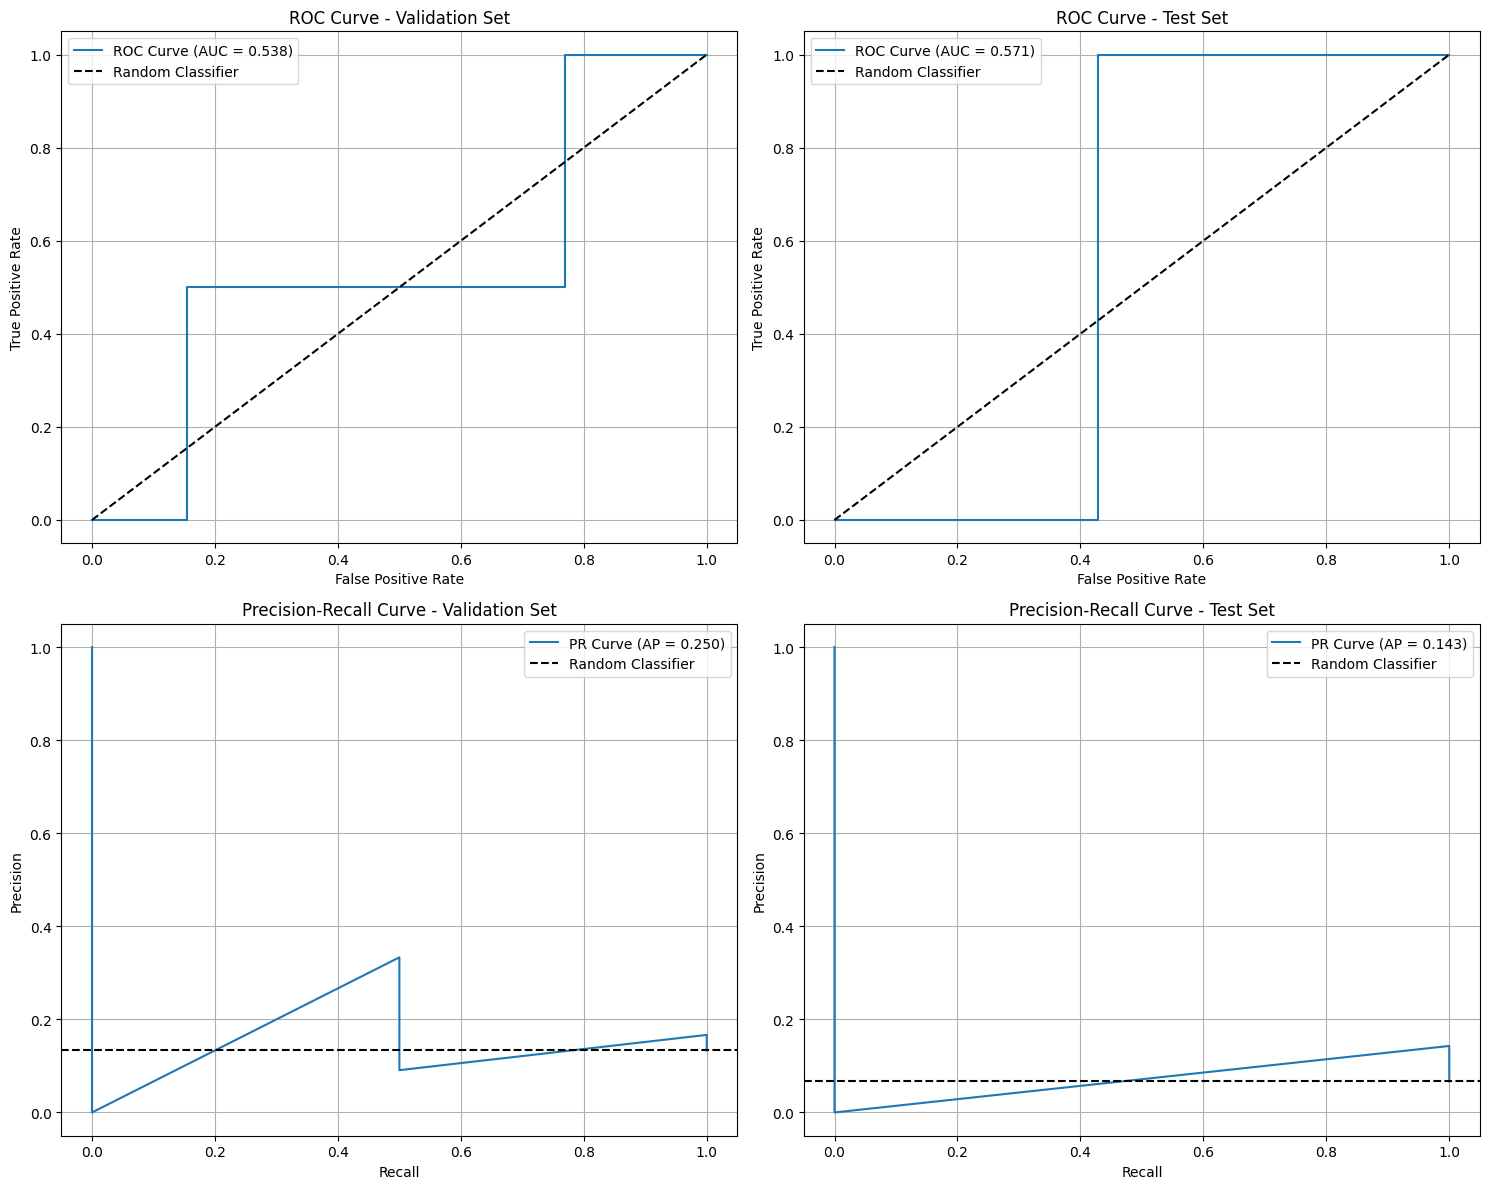

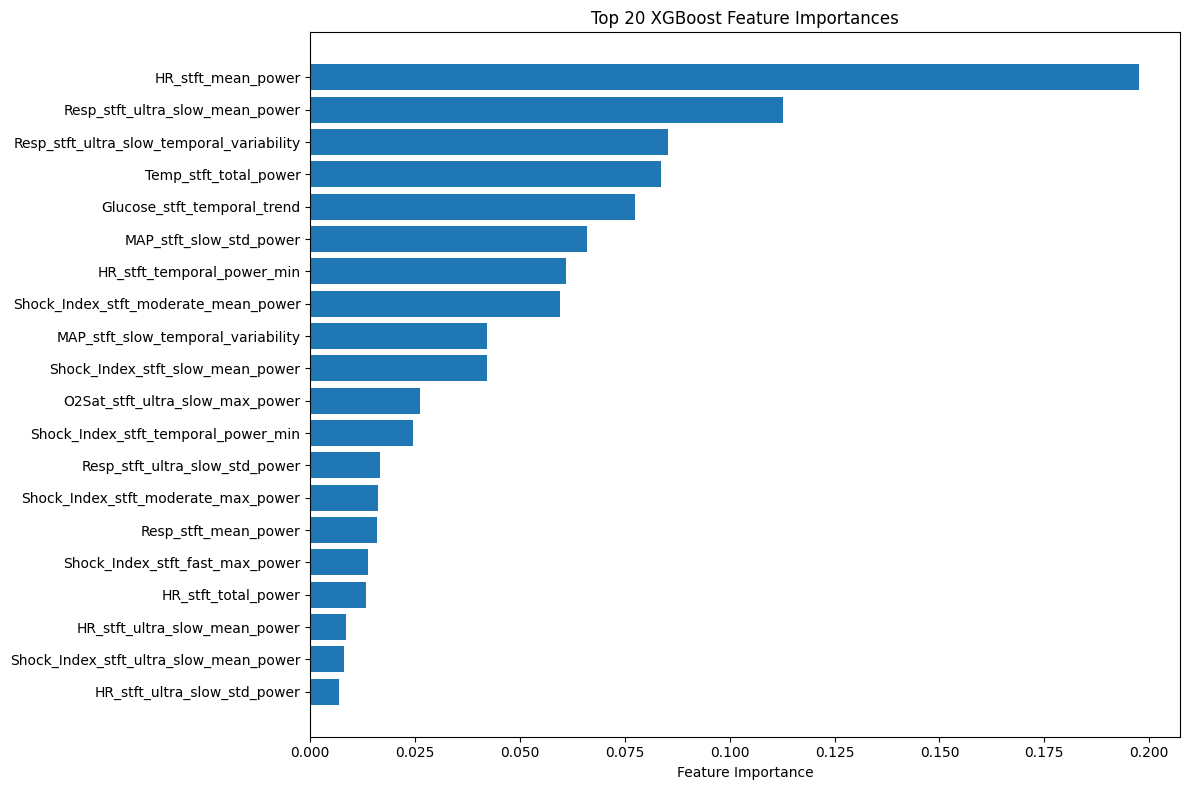

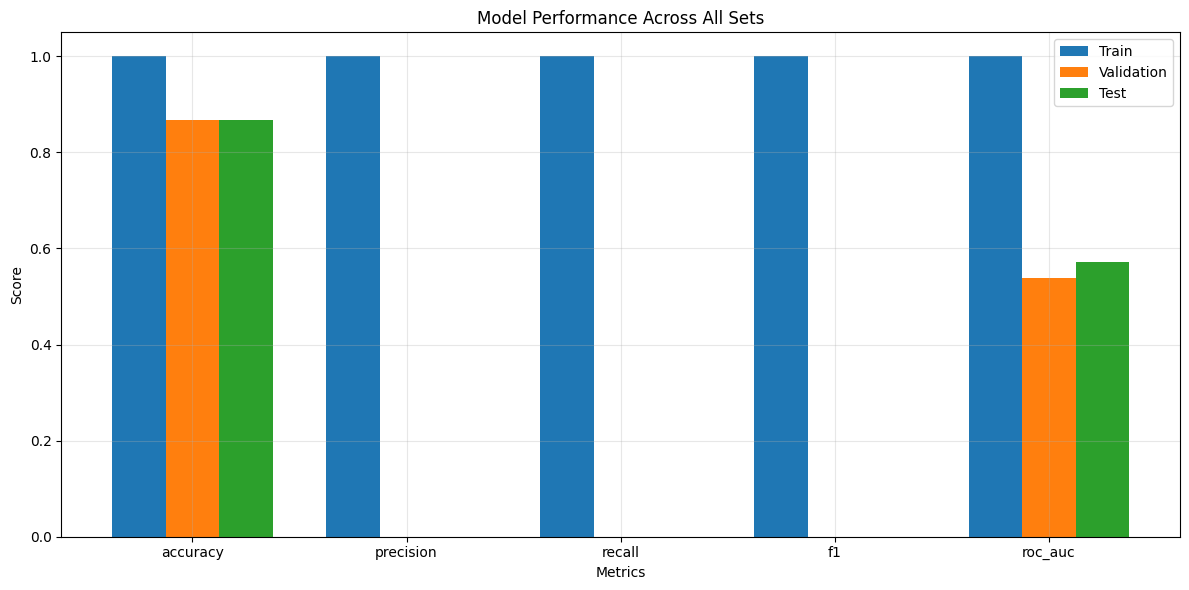

In [18]:
# Visualize model performance
print("=== PERFORMANCE VISUALIZATION ===")

# ROC curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
for i, (set_name, results) in enumerate([('Validation', val_results), ('Test', test_results)]):
    if i < 2:
        y_true = y_val if set_name == 'Validation' else y_test
        fpr, tpr, _ = roc_curve(y_true, results['y_pred_proba'])
        
        axes[0, i].plot(fpr, tpr, label=f'ROC Curve (AUC = {results["roc_auc"]:.3f})')
        axes[0, i].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC Curve - {set_name} Set')
        axes[0, i].legend()
        axes[0, i].grid(True)

# Precision-Recall curves
for i, (set_name, results) in enumerate([('Validation', val_results), ('Test', test_results)]):
    if i < 2:
        y_true = y_val if set_name == 'Validation' else y_test
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, results['y_pred_proba'])
        
        axes[1, i].plot(recall_curve, precision_curve, label=f'PR Curve (AP = {results["avg_precision"]:.3f})')
        axes[1, i].axhline(y=y_true.mean(), color='k', linestyle='--', label='Random Classifier')
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall Curve - {set_name} Set')
        axes[1, i].legend()
        axes[1, i].grid(True)

plt.tight_layout()
plt.show()

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance_xgb.head(20)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Performance comparison bar chart
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
sets = ['Train', 'Validation', 'Test']
results_data = [train_results, val_results, test_results]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.25

for i, (set_name, results) in enumerate(zip(sets, results_data)):
    values = [results[metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=set_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Across All Sets')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== SHAP ANALYSIS FOR MODEL INTERPRETABILITY ===
Creating SHAP explainer...
Calculating SHAP values for 15 test samples...


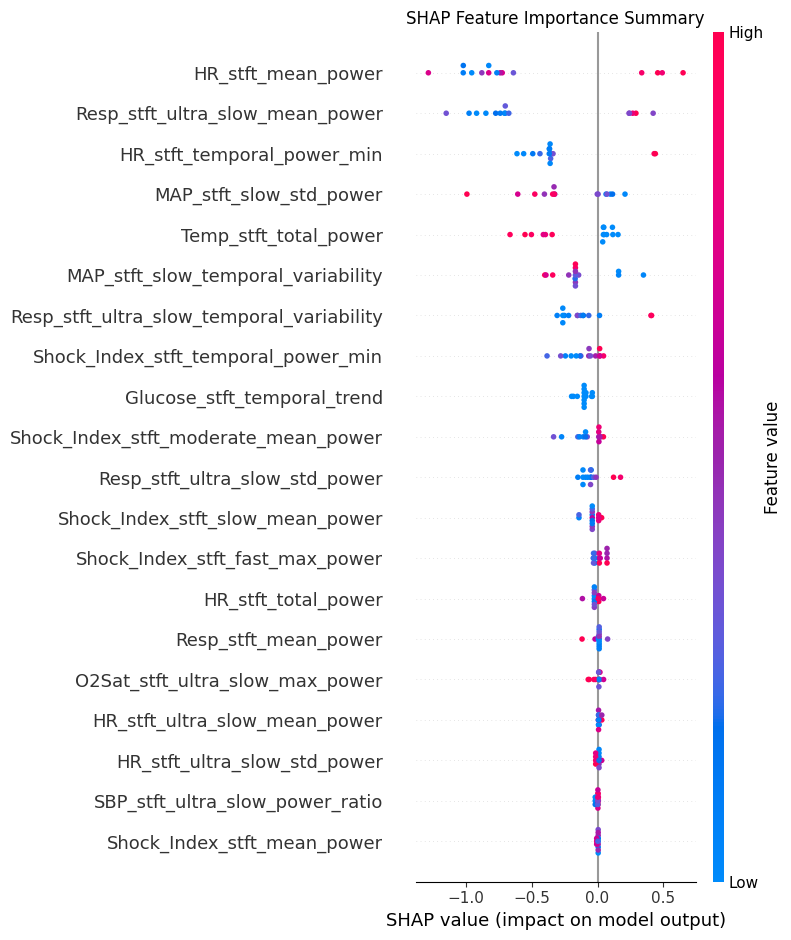


Top 15 SHAP feature importances:


,Feature,SHAP_Importance
1,HR_stft_mean_power,0.773047
73,Resp_stft_ultra_slow_mean_power,0.642358
8,HR_stft_temporal_power_min,0.411997
61,MAP_stft_slow_std_power,0.290563
21,Temp_stft_total_power,0.236349
63,MAP_stft_slow_temporal_variability,0.222429
76,Resp_stft_ultra_slow_temporal_variability,0.207537
98,Shock_Index_stft_temporal_power_min,0.121467
99,Glucose_stft_temporal_trend,0.102978
87,Shock_Index_stft_moderate_mean_power,0.092494


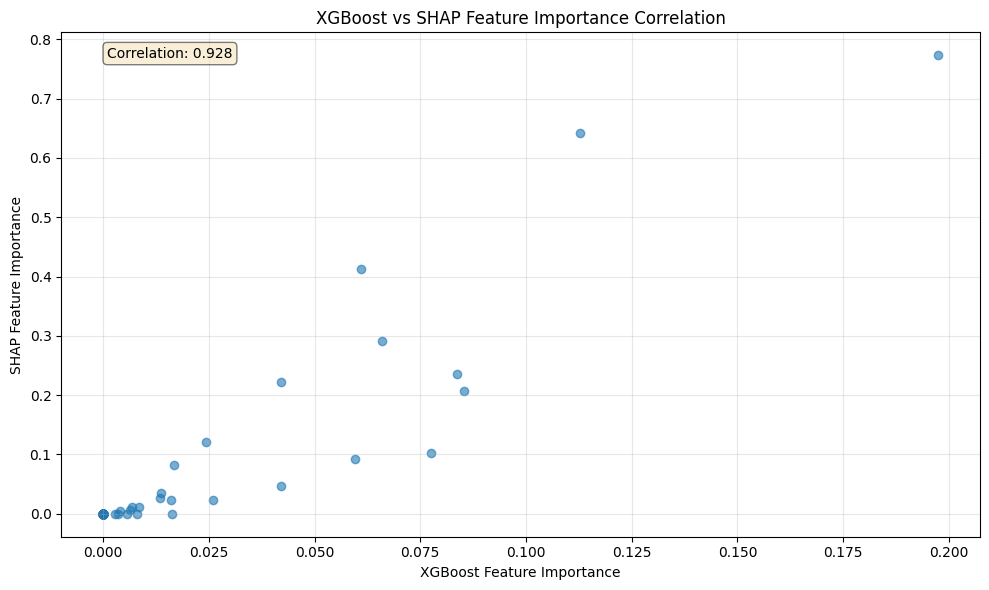

In [19]:
# SHAP analysis for model interpretability
print("=== SHAP ANALYSIS FOR MODEL INTERPRETABILITY ===")

try:
    # Create SHAP explainer
    print("Creating SHAP explainer...")
    explainer = shap.TreeExplainer(final_xgb)
    
    # Calculate SHAP values for test set (sample for efficiency)
    sample_size = min(100, len(X_test_selected))
    test_sample_indices = np.random.choice(len(X_test_selected), sample_size, replace=False)
    X_test_sample = X_test_selected[test_sample_indices]
    
    print(f"Calculating SHAP values for {sample_size} test samples...")
    shap_values = explainer.shap_values(X_test_sample)
    
    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=selected_features, show=False)
    plt.title('SHAP Feature Importance Summary')
    plt.tight_layout()
    plt.show()
    
    # SHAP feature importance
    shap_importance = np.abs(shap_values).mean(0)
    shap_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print(f"\nTop 15 SHAP feature importances:")
    display(shap_importance_df.head(15))
    
    # Compare SHAP vs XGBoost importance
    comparison_df = pd.merge(
        feature_importance_xgb[['Feature', 'Importance']], 
        shap_importance_df[['Feature', 'SHAP_Importance']], 
        on='Feature'
    )
    
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison_df['Importance'], comparison_df['SHAP_Importance'], alpha=0.6)
    plt.xlabel('XGBoost Feature Importance')
    plt.ylabel('SHAP Feature Importance')
    plt.title('XGBoost vs SHAP Feature Importance Correlation')
    
    # Add correlation coefficient
    correlation = comparison_df['Importance'].corr(comparison_df['SHAP_Importance'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    print("Continuing without SHAP analysis...")
    shap_importance_df = None

In [21]:
# Save model and results
print("=== SAVING MODEL AND RESULTS ===")

# Save the trained model
joblib.dump(final_xgb, os.path.join(MODEL_PATH, 'xgboost_with_stft_model.pkl'))
print(f"Model saved: xgboost_with_stft_model.pkl")

# Save the feature selector
joblib.dump(selector, os.path.join(MODEL_PATH, 'feature_selector.pkl'))
print(f"Feature selector saved: feature_selector.pkl")

# Save feature importance results
feature_importance_xgb.to_csv(os.path.join(RESULTS_PATH, 'xgboost_feature_importance.csv'), index=False)
feature_importance_df.to_csv(os.path.join(RESULTS_PATH, 'univariate_feature_importance.csv'), index=False)

if shap_importance_df is not None:
    shap_importance_df.to_csv(os.path.join(RESULTS_PATH, 'shap_feature_importance.csv'), index=False)

# Save selected features
with open(os.path.join(RESULTS_PATH, 'selected_features.txt'), 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

# Save model performance results
performance_summary = {
    'model_type': 'XGBoost with STFT and SMOTE',
    'smote_method': chosen_smote,
    'total_features': len(all_feature_cols),
    'selected_features': len(selected_features),
    'traditional_features': len(selected_traditional),
    'stft_features': len(selected_stft),
    'best_params': best_params,
    'performance': {
        'train': {k: v for k, v in train_results.items() if k not in ['y_pred', 'y_pred_proba']},
        'validation': {k: v for k, v in val_results.items() if k not in ['y_pred', 'y_pred_proba']},
        'test': {k: v for k, v in test_results.items() if k not in ['y_pred', 'y_pred_proba']}
    },
    'cv_score': {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores.tolist()
    },
    'feature_importance_breakdown': {
        'traditional_importance': float(xgb_traditional_importance),
        'stft_importance': float(xgb_stft_importance)
    },
    'smote_metadata': smote_metadata
}

# Convert numpy types to Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

performance_summary = convert_numpy_types(performance_summary)

# Save performance summary
with open(os.path.join(RESULTS_PATH, 'xgboost_performance_summary.pkl'), 'wb') as f:
    pickle.dump(performance_summary, f)

# Save predictions
predictions_df = pd.DataFrame({
    'patient_id': test_integrated['patient_id'].values,
    'True_Label': y_test,
    'Predicted_Label': test_results['y_pred'],
    'Predicted_Probability': test_results['y_pred_proba']
})
predictions_df.to_csv(os.path.join(RESULTS_PATH, 'test_predictions.csv'), index=False)

print(f"\n=== MODEL TRAINING COMPLETED ===\n")
print(f"Summary:")
print(f"- Model: XGBoost with STFT features and {chosen_smote}")
print(f"- Total features: {len(all_feature_cols)} -> {len(selected_features)} selected")
print(f"- Traditional features: {len(selected_traditional)} ({len(selected_traditional)/len(selected_features)*100:.1f}%)")
print(f"- STFT features: {len(selected_stft)} ({len(selected_stft)/len(selected_features)*100:.1f}%)")
print(f"\nTest Set Performance:")
print(f"- ROC-AUC: {test_results['roc_auc']:.4f}")
print(f"- Precision: {test_results['precision']:.4f}")
print(f"- Recall: {test_results['recall']:.4f}")
print(f"- F1-Score: {test_results['f1']:.4f}")
print(f"\nFeature Importance (Traditional vs STFT):")
print(f"- Traditional: {xgb_traditional_importance:.4f} ({xgb_traditional_importance/(xgb_traditional_importance+xgb_stft_importance)*100:.1f}%)")
print(f"- STFT: {xgb_stft_importance:.4f} ({xgb_stft_importance/(xgb_traditional_importance+xgb_stft_importance)*100:.1f}%)")
print(f"\nFiles saved to: {RESULTS_PATH}")
print(f"\nNext steps:")
print(f"1. Build ensemble models combining multiple algorithms")
print(f"2. Comprehensive validation and testing")
print(f"3. Clinical interpretability analysis")
print(f"4. Model deployment preparation")

=== SAVING MODEL AND RESULTS ===
Model saved: xgboost_with_stft_model.pkl
Feature selector saved: feature_selector.pkl

=== MODEL TRAINING COMPLETED ===

Summary:
- Model: XGBoost with STFT features and SMOTE
- Total features: 475 -> 100 selected
- Traditional features: 0 (0.0%)
- STFT features: 100 (100.0%)

Test Set Performance:
- ROC-AUC: 0.5714
- Precision: 0.0000
- Recall: 0.0000
- F1-Score: 0.0000

Feature Importance (Traditional vs STFT):
- Traditional: 0.0000 (0.0%)
- STFT: 1.0000 (100.0%)

Files saved to: C:\Users\sachi\Desktop\Sepsis STFT\results

Next steps:
1. Build ensemble models combining multiple algorithms
2. Comprehensive validation and testing
3. Clinical interpretability analysis
4. Model deployment preparation
